<a href="https://colab.research.google.com/github/the-pinbo/image-denoising/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Montamos nuestra unidad drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# srcPath = '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images'
#srcPath = 'data/BSDS300/images'
srcPath = '/content/drive/MyDrive/bsd_images/images'

train_scan_paths = os.listdir(srcPath + '/train')
test_scan_paths = os.listdir(srcPath + '/test')

train_scan_paths = [(srcPath + '/train/' + x) for x in train_scan_paths]
test_scan_paths = [(srcPath + '/test/' + x) for x in test_scan_paths]


print("train scan with length of: {}".format(len(train_scan_paths)))
print("test scan with length of: {}".format(len(test_scan_paths)))

train scan with length of: 200
test scan with length of: 200


In [ ]:
train_scan_paths[:5]

['/content/drive/MyDrive/bsd_images/images/train/130034.jpg',
 '/content/drive/MyDrive/bsd_images/images/train/134052.jpg',
 '/content/drive/MyDrive/bsd_images/images/train/109034.jpg',
 '/content/drive/MyDrive/bsd_images/images/train/118035.jpg',
 '/content/drive/MyDrive/bsd_images/images/train/113009.jpg']

In [ ]:
test_scan_paths[:5]

['/content/drive/MyDrive/bsd_images/images/test/10081.jpg',
 '/content/drive/MyDrive/bsd_images/images/test/104055.jpg',
 '/content/drive/MyDrive/bsd_images/images/test/120093.jpg',
 '/content/drive/MyDrive/bsd_images/images/test/112090.jpg',
 '/content/drive/MyDrive/bsd_images/images/test/109055.jpg']

In [ ]:
# def normalize_scan(image):

#   norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

#   return norm_image

# def resize_scan(scan, desired_width, desired_height):
  
#   scan = cv2.resize(scan, (desired_height, desired_width))

#   return scan

# def preprocess_scan(path, width, height):
  
#   scan = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)  
#   resized_scan = resize_scan(scan, width, height)  
#   normalized_resized_scan = normalize_scan(resized_scan)

#   return normalized_resized_scan

# def generate_img(image): 
#   plt.axis("off")
#   plt.imshow(image)
#   plt.show()
  
# def generate_img_2(image): 
#   img = plt.imshow(image)
#   # img.set_cmap('hot')
#   plt.axis('off')
#   # plt.show()
def normalize_scan(image):

  norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  return norm_image

def resize_scan(scan, desired_width, desired_height):
  
  scan = cv2.resize(scan, (desired_height, desired_width))

  return scan

def preprocess_scan(path, width, height):
  
  scan = cv2.imread(path)  
  resized_scan = resize_scan(scan, width, height)  
  normalized_resized_scan = normalize_scan(resized_scan)

  return normalized_resized_scan

def generate_img(image): 
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
def generate_img_2(image): 
  img = plt.imshow(image)
  # img.set_cmap('hot')
  plt.axis('off')
  # plt.show()

In [ ]:
width = 256
height = 256

In [ ]:
train_scans = [preprocess_scan(path, width, height) for path in train_scan_paths]
test_scans = [preprocess_scan(path, width, height) for path in test_scan_paths]

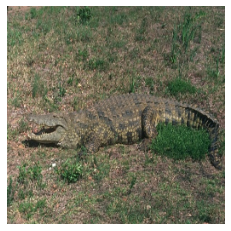

In [ ]:
data = train_scans[0]

generate_img(data)
# plt.axis("off")
# plt.imshow(cv2.cvtColor(data, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out
  
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

    ##Added new
  elif noise_typ == "bernoulli":
    N = 100
    P = 0.5
    bernoulli = np.random.binomial(n = N, p = P, size = image.shape)
    noisy = bernoulli + image
    return noisy

In [ ]:
# N = 100
# P = 0.7
# bernoulli = np.random.binomial(n = N, p = P, size = (img.shape[0], img.shape[1], 3))
# print(bernoulli.shape)
# noisy = img + bernoulli
# fig = plt.figure()
# fig.add_subplot(121)
# plt.imshow(img)
# fig.add_subplot(122)
# plt.imshow(noisy)

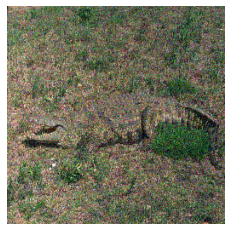

In [ ]:
image = train_scans[0]
noisyimg = noisy('gauss', image)
generate_img(noisyimg.astype('float32'))

In [ ]:
train_gaussian_noise_images = np.array([noisy('gauss', x) for x in train_scans])
test_gaussian_noise_images = np.array([noisy('gauss', x) for x in test_scans])

train_target_images = np.array(train_scans)
test_target_images = np.array(test_scans)

In [ ]:
# Funcion de perdida - MSE
from tensorflow.keras.losses import MeanSquaredError

mse = tf.keras.losses.MeanSquaredError()
mse(train_gaussian_noise_images[0], train_scans[0]).numpy()

0.009989612

In [ ]:
# Batch size
BATCH_SIZE = 10

# Train size
train_gaussian_noise_images.shape

(200, 256, 256, 3)

In [ ]:
from keras import Input, Model, Sequential
from keras import layers
from keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast, RandomRotation

K.clear_session()

In [ ]:
data_augmentation = Sequential(
    [
     RandomFlip(mode="horizontal",seed=0),
     RandomContrast(0.1,seed=0)     
     ]
)

In [ ]:
def Autoencoder():
  
  input_img = Input(shape=(256, 256, 3))  
  augmentation = data_augmentation(input_img)
  # ============================================================================
  # == ENCODER
  # ============================================================================

  conv_1_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(augmentation)
  l_relu_1_a = layers.LeakyReLU()(conv_1_a)
  conv_1_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(l_relu_1_a)
  l_relu_1_b = layers.LeakyReLU()(conv_1_b)
  maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_1_b)
  #print(maxpool_1.shape)

  conv_2 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_1)
  l_relu_2 = layers.LeakyReLU()(conv_2)
  maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_2)
  #print(maxpool_2.shape)

  conv_3 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_2)
  l_relu_3 = layers.LeakyReLU()(conv_3)
  maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_3)
  #print(maxpool_3.shape)

  conv_4 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_3)
  l_relu_4 = layers.LeakyReLU()(conv_4)
  maxpool_4 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_4)
  #print(maxpool_4.shape)

  conv_5_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_4)
  l_relu_5_a = layers.LeakyReLU()(conv_5_a)
  maxpool_5 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_5_a)
  #print(maxpool_5.shape)

  conv_5_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_5)
  encoded = layers.LeakyReLU()(conv_5_b)

  # ============================================================================
  # == DECODER
  # ============================================================================

  upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
  #print(upsamp_6.shape)
  concat_6 = tf.concat([upsamp_6, maxpool_4], axis=3)
  #print(concat_6.shape)
  conv_6_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_6)
  l_relu_6_a = layers.LeakyReLU()(conv_6_a)
  conv_6_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_6_a)
  l_relu_6_b = layers.LeakyReLU()(conv_6_b)
  
  upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
  #print(upsamp_7.shape)
  concat_7 = tf.concat([upsamp_7, maxpool_3], axis=3)
  #print(concat_7.shape)
  conv_7_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_7)
  l_relu_7_a = layers.LeakyReLU()(conv_7_a)
  conv_7_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_7_a)
  l_relu_7_b = layers.LeakyReLU()(conv_7_b)

  upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
  #print(upsamp_8.shape)
  concat_8 = tf.concat([upsamp_8, maxpool_2], axis=3)
  #print(concat_8.shape)
  conv_8_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_8)
  l_relu_8_a = layers.LeakyReLU()(conv_8_a)
  conv_8_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_8_a)
  l_relu_8_b = layers.LeakyReLU()(conv_8_b)

  upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
  #print(upsamp_9.shape)
  concat_9 = tf.concat([upsamp_9, maxpool_1], axis=3)
  #print(concat_9.shape)
  conv_9_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_9)
  l_relu_9_a = layers.LeakyReLU()(conv_9_a)
  conv_9_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_9_a)
  l_relu_9_b = layers.LeakyReLU()(conv_9_b)

  upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
  #print(upsamp_10.shape)
  concat_10 = tf.concat([upsamp_10, input_img], axis=3)
  #print(concat_10.shape)
  conv_10_a = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(concat_10)
  l_relu_10_a = layers.LeakyReLU()(conv_10_a)
  conv_10_b = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(l_relu_10_a)
  l_relu_10_b = layers.LeakyReLU()(conv_10_b)

  decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_10_b)
  #print(decoded.shape)
  # decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_7_b)

  return Model(input_img, decoded)

In [ ]:
autoencoder = Autoencoder()

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
# def REDNet():

#   inp = Input(shape = (256, 256, 3))
#   augmentation = data_augmentation(inp)
#   conv1 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(augmentation)
#   conv22 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(conv1)
#   conv3 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(conv2)
#   conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(conv3)
#   conv5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(conv4)  
#   tranconv1 = Conv2DTranspose(128, (3, 3), padding = 'same', activation = 'relu')(conv5)
#   s1 = Add()([tranconv1, l4])
#   tranconv2 = Conv2DTranspose(128, (3, 3), padding = 'same', activation = 'relu')(s1)
#   s2 = Add()([l7, l3])
#   tranconv3 = Conv2DTranspose(128, (3, 3), padding = 'same', activation = 'relu')(s2)
#   s3 = Add()([l8, l2])
#   tranconv4 = Conv2DTranspose(128, (3, 3), padding = 'same', activation = 'relu')(s3)
#   s4 = Add()([l9, l1])
#   op = Conv2DTranspose(3, (3, 3), padding = 'same', activation = 'relu')(s4)
  
#   model = Model(inp, op)
#   return model    
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
def REDNet():

    il = Input(shape = (256, 256, 3))
    augmentation = data_augmentation(il)
    l1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu', )(augmentation)
    l2 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(l1)
    l3 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(l2)
    l4 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(l3)
    l5 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(l4)  
    l6 = Conv2DTranspose(16, (3, 3), padding = 'same', activation = 'relu')(l5)
    s1 = Add()([l6, l4])
    l7 = Conv2DTranspose(16, (3, 3), padding = 'same', activation = 'relu')(s1)
    s2 = Add()([l7, l3])
    l8 = Conv2DTranspose(16, (3, 3), padding = 'same', activation = 'relu')(s2)
    s3 = Add()([l8, l2])
    l9 = Conv2DTranspose(16, (3, 3), padding = 'same', activation = 'relu')(s3)
    s4 = Add()([l9, l1])
    l10 = Conv2DTranspose(3, (3, 3), padding = 'same', activation = 'relu')(s4)
  
    model = Model(il, l10)
    return model

In [ ]:
autoencoder = REDNet()

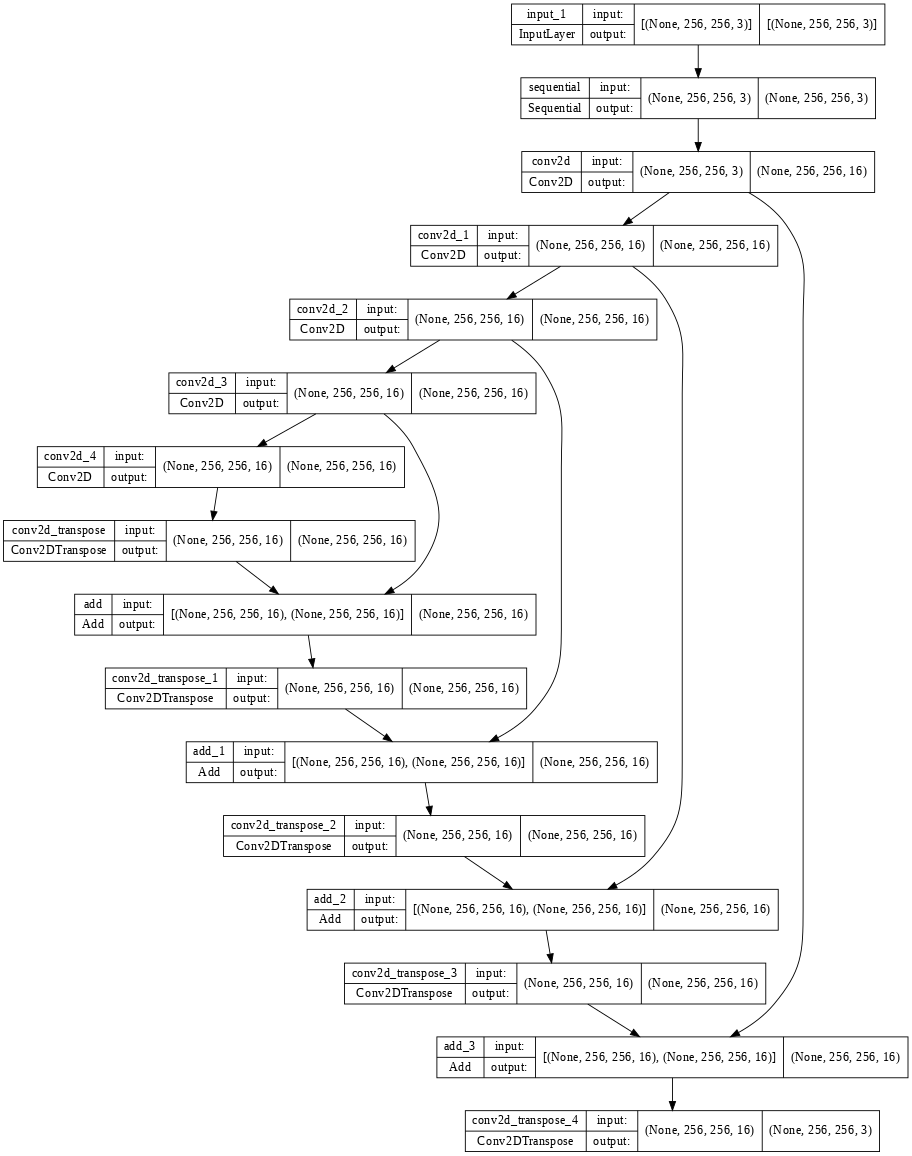

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, show_shapes=True, dpi=64)

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['sequential[0][0]']             
                                )                                                                 
                                                                                              

In [ ]:
%cd /content/drive/My Drive/TA_02_TAC

[Errno 2] No such file or directory: '/content/drive/My Drive/TA_02_TAC'
/content


In [ ]:
from tensorflow.keras.optimizers import Adam

# Definimos la funcion de optimizacion
autoencoder_optimizer = Adam(0.0001, beta_1=0.9)

In [ ]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "my_model/model_gauss_10"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [ ]:
# from tensorflow.keras.preprocessing import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1/255.)

# train_generator = train_datagen.flow_from_directory()

In [ ]:
EPOCHS = 40
history = autoencoder.fit(train_gaussian_noise_images, train_target_images,
                epochs=EPOCHS,
                shuffle=True,
                validation_data=(test_gaussian_noise_images, test_target_images), callbacks=[model_checkpoint])

Epoch 1/40
7/7 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.4059
Epoch 1: val_accuracy improved from -inf to 0.37287, saving model to my_model/model_gauss_10
7/7 [==============================] - 14s 461ms/step - loss: 0.1295 - accuracy: 0.4059 - val_loss: 0.0692 - val_accuracy: 0.3729
Epoch 2/40
7/7 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.3815
Epoch 2: val_accuracy did not improve from 0.37287
7/7 [==============================] - 2s 328ms/step - loss: 0.0610 - accuracy: 0.3815 - val_loss: 0.0195 - val_accuracy: 0.3663
Epoch 3/40
7/7 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.4754
Epoch 3: val_accuracy improved from 0.37287 to 0.54214, saving model to my_model/model_gauss_10
7/7 [==============================] - 2s 330ms/step - loss: 0.0409 - accuracy: 0.4754 - val_loss: 0.0183 - val_accuracy: 0.5421
Epoch 4/40
7/7 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.5192
Epoc

In [ ]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

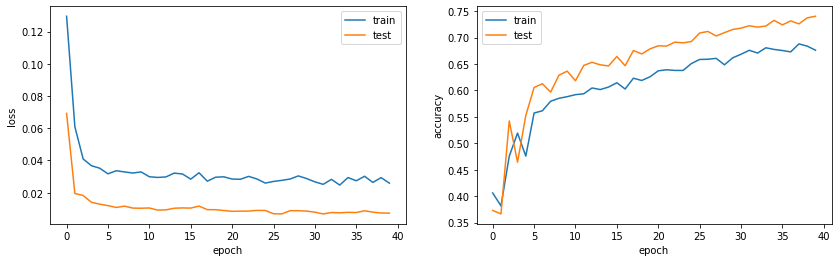

In [ ]:
show_results(history)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model.predict(test_input.reshape(-1,256,256,3))
  plt.figure(figsize=(15, 15))

  display_list = [test_input.astype('float32'), tar.astype('float32'), prediction.reshape(256,256,3)]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])

    plt.axis("off")
    plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    # img = plt.imshow(tf.cast((display_list[i] * 255),np.uint8))
    # # img.set_cmap('hot')
    # plt.axis('off')
    # print("OK 3")
    # plt.imshow(display_list[i])
    # plt.axis('off')

  plt.show()

In [ ]:
## Visualizamos algunas prediccinoes
for inp, tar in zip(test_gaussian_noise_images[:5], test_target_images[:5]):
  generate_images(autoencoder, inp, tar)

In [ ]:
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def plot_comparison(input_image, target_image, prediction):
    plt.figure(figsize=(15, 15))

    display_list = [input_image.astype('float32'), target_image.astype('float32'), prediction.astype('float32')]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.axis("off")
      plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# Realizamos predicciones a las imagenes de testing y obtenemos el PSNR
list_test_predictions = []
list_PSNR = []
for inp, tar in zip(test_gaussian_noise_images, test_target_images):
    prediction = autoencoder.predict(inp.reshape(-1,256,256,3))
    prediction = prediction.reshape(256,256,3)
    list_test_predictions.append(prediction)
    list_PSNR.append(PSNR(tar, prediction))

In [ ]:
np.array([100 - x for x in list_PSNR]).mean()

30.259653733162992

In [ ]:
# TOP 5 RESULTADOS
for index in np.array(list_PSNR).argsort()[-5:]:
  plot_comparison(test_gaussian_noise_images[index], test_target_images[index],list_test_predictions[index])